# HW Tool
# Бышков Олег

## 1. `shap.plots.beeswarm` нормального человека (6 баллов)

Как вы могли видеть, у встроенного beeswarm plot`а есть несколько недостатков:
- нет информации о том, какие именно значения категориальных признаков в какую сторону толкают предсказания модели
- иногда серые точки (пропущенные значения) прячутся за точками другого цвета -> их не видно (см. rooms_num на графике с семинара)
- иногда раскраска бывает некорректной (потому что она раскрашивает по абсолютным значениям)

Вам предлагается реализовать свою версию shap.plots.beeswarm, которая исправляет эти недостатки.


Итак, требуется написать функцию, которая принимает на вход shap_values и все необходимое и строит по этим данным beeswarm plot
    без вышеперечисленных недостатков, а именно:
- теперь все уникальные значения кат. фич становятся как бы отдельными фичами, по ним видны shap_values (см. пример)
    - чтобы не захламлять ваш график редковстречающимися категориями, принимайте на вход параметр, чтобы контролировать это
    - такие фичи должны быть покрашены в особый цвет, чтобы отличаться от числовых
- точки, отвечающие за наны, должны быть хорошо видны на фоне остальных и не перекрывать их
- раскраска должна адекватно красить ваши точки
    - можно выкидывать выбросы перед покраской
    - можно логарифмировать значения
    - можно красить по квантилям, а не по абсолютным значениям
    - лучше всего красятся равномерное и нормальное распределение

**Обязательно:**
- docstring
- комменты к непонятным кускам кода - что там происходит
- принимайте на вход кол-во фич, которые вы отображаете на графике
- принимайте на вход размер фигуры
- нарисуйте вертикальную линию, обозначающую 0
- сортируйте признаки по среднему модулю shap_values
- используйте stripplot (или аналоги) с jitter`ом, а не swarmplot
- принимайте на вход кол-во точек которое будете отрисовывать (500-3000 = норм)
    - если для какого-то значения кат фичи точек меньше, чем вы задали, рисуйте сколько есть

**!**
Если на вход подана слишком большая выборка, вы можете под капотом сэмплить из нее какое-то адекватное кол-во точек и отрисовывать их.
Однако, раскраску и контроль за отрисовкой категорий лучше базировать на всей выборке, поданной на вход.


Ниже приведен пример. Не меняйте код, предшествующий примеру. Вы не обязаны повторять пример точь-в-точь, это ориентир. Не удаляйте пример.

Удачи!

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [ ]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    path_to_df = "/content/drive/MyDrive/Colab Notebooks/aim_ml2_hw3/train_sber.parquet"
    path_to_model = "/content/drive/MyDrive/Colab Notebooks/aim_ml2_hw3/model.lgb"
else:
    path_to_df = "datasets/train_sber.parquet"
    path_to_model = "models/model.lgb"

Mounted at /content/drive


In [ ]:
import numpy as np, pandas as pd
import lightgbm as lgb
import sys
import os
import warnings

%load_ext autoreload
%autoreload 2


df = pd.read_parquet(path_to_df)
features = df.columns.drop(['timestamp', 'result_price', 'result_price_bin'])

model = lgb.Booster(model_file=path_to_model)
shap_values = model.predict(df[features], pred_contrib=True)

'''
Учтите, что если вы считаете shap_values через LightGBM,
    shap_values - np.array of shape (N, F + 1), где последний столбец - константа = среднее предсказание для всех объектов
'''
print('features shape:', features.shape, 'shap_values shape:', shap_values.shape)
df.head(3)

[LightGBM] [Warning] Ignoring unrecognized parameter 'bagging_by_query' found in model string.
features shape: (36,) shap_values shape: (27232, 37)


,district_area,road_distance_1,road_distance_2,year_of_construction,bulvar_ring_km,bus_station_distance,cafe_count,fitness_center_distance,floor,district_population,...,public_transport_station_distance,sadovoe_km,base_school_distance,sport_count,state,district_name,timestamp,malls_count,railway_station_distance,result_price_bin
0,6407578.100,1.422391,3.830951,NaN,13.675657,24.292406,152,0.485841,4.0,86206,...,3.299822,13.100618,0.177975,52,NaN,Bibirevo,2011-08-20,52,14.231961,False
1,9589336.912,2.887377,3.103996,NaN,8.132640,5.706113,177,0.668364,3.0,76284,...,0.783160,6.444333,0.273345,66,NaN,Nagatinskij Zaton,2011-08-23,40,9.242586,False
2,4808269.831,0.647250,2.927487,NaN,8.054252,6.710302,122,0.733101,2.0,101982,...,3.945073,6.963403,0.158072,67,NaN,Tekstil'shhiki,2011-08-27,35,9.540544,False


In [ ]:
from typing import List, Optional, Tuple
from IPython import display

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def get_df_info(df: pd.DataFrame, thr: float = 0.01, accur: int = 3, sort_by_index: bool = True):
    '''
    Возвращает поколоночную информацию о датафрейме в другом датафрейме.
    Если датафрейм пустой, вернется None.

    Все колонки имеют тип 'string' (для удобства работы), кроме
    'example_1' и 'example_2', которые имеют тип как в датафреме.

    Параметры
    ----------
    df : pandas датафрейм
    thr : float значение в диапазоне [0, 1]
        До какого значения считать долю медианных элементов
        нормальной. Если доля будет больше указанного значения,
        то будут учавствовать в подсчете trash_score
    accur : int в диапазоне >= 0
        Используется в округлении эначений в датафрейме

    Возвращает
    ----------
        датафрейм с информацией о колонках
    '''
    n, m = len(df), len(df.columns) # table (n x m)
    if n == 0:
        return None

    pd.Series

    # datamining for df_info (everything by columns)
    dtypes = pd.Series(df.dtypes, copy=True)
    unique = df.nunique(dropna=False) # include null
    nan = (1 - df.notnull().sum() / n).round(accur)
    zero = ((df == 0).sum() / n).round(accur)
    empty_str = ((df == '').sum() / n).round(accur)


    mode_v = df.mode(dropna=True).iloc[0] # exclude null
    # get count of elements == mode
    mode_c = [(df.iloc[:,i] == mode_v.iloc[i]).sum() / n for i in range(m)]
    mode_c = pd.Series(mode_c).round(accur)

    trash_x1 = nan + zero + empty_str
    trash_x2 = (mode_c > thr) * mode_v
    # apply max((nan + zero + empty_str), mode * (if more than normal))
    trash_score = pd.DataFrame(
        list(zip(trash_x1, trash_x2)
    ), copy=False).max(axis=1).round(3)

    # get two different! examples
    examples = df.sample(2, replace=False)
    example_1 = examples.iloc[0]
    example_2 = examples.iloc[1]


    # change types for replase 0.000 to -1
    replace_dict = {'0.0': '-1'} # replace by dictionary, not by str.replace!
    unique = unique.astype('string').replace(replace_dict)
    nan = nan.astype('string').replace(replace_dict)
    zero = zero.astype('string').replace(replace_dict)
    empty_str = empty_str.astype('string').replace(replace_dict)
    mode_c = mode_c.astype('string').replace(replace_dict)
    trash_score = trash_score.astype('string').replace(replace_dict)
    dtypes = dtypes.astype('string').replace({'string[python]': 'string'})

    # df_info props
    cols = ['dtypes', 'unique', 'nan', 'zero', 'empty_str', 'mode_v', 'mode_c', 'trash_score', 'example_1', 'example_2']
    cols = pd.Series(cols)
    data = list(zip(dtypes, unique, nan, zero, empty_str, mode_v, mode_c, trash_score, example_1, example_2))

    # make and ret df_info
    df_info = pd.DataFrame(data, index=df.columns, columns=cols)
    # sorting in lexicographic order for convenient
    if sort_by_index:
        df_info.sort_index(inplace=True)

    return df_info.reindex(sorted(df_info.columns), axis=1)

In [ ]:
def split_cat_features(
    dataset: pd.DataFrame,
    shap_values: np.ndarray,
    top_k_cat: Optional[int] = None,
    min_samples_cat: Optional[int] = None,
    drop_last_shap_col: bool = True,
    deep_copy=False # if in/out dataframes is read-only then save 'False'
) -> Tuple[pd.DataFrame, np.ndarray]:
    """
    Обрабатывает категориальные признаки, разделяя их на отдельные бинарные колонки (типа OHE).

    Для каждой категории создает новую колонку в датафрейме с суффиксом '_<значение>'.
    Категории фильтруются следующими правилами:
    - Сохраняются top_k_cat самых частых категорий
    - Игнорируются категории с числом образцов < min_samples_cat

    Отфильтрованные категории попадают в колонку с суффиксом '_Other'

    Параметры:
        dataset: DataFrame с категориальными признаками
        shap_values: Массив SHAP-значений (shape: [n_samples, n_features])
        top_k_cat: Максимальное количество split-ов для признака
        min_samples_cat: Минимальное число образцов для создания отдельного split-а
        drop_last_shap_col: Удалять ли последний столбец SHAP-значений (lgb сохраняет)
        deep_copy: Создавать глубокую копию данных (для ronly операция оставлять False)

    Возвращает:
        Модифицированный DataFrame и обновленный массив SHAP-значений
    """
    splitted_shaps = []
    drop_cols = []
    dataset = dataset.copy(deep=deep_copy)

    for i, (col_name, col_dtype) in enumerate(zip(dataset.columns, dataset.dtypes)):
        if col_dtype != 'category':
            continue

        # есть поддержка обработки NA значений
        hist_col = dataset[col_name].value_counts(dropna=False).sort_values(ascending=False)

        # если уникальных < 2 - то нечего делить
        if hist_col.shape[0] < 2:
            continue

        top_k_cat_col = hist_col.shape[0]

        # фильтрация по топ значений
        if top_k_cat is not None:
            top_k_cat_col = min(top_k_cat_col, top_k_cat)

        # фильтрация по количеству в бине
        if min_samples_cat is not None:
            top_k_cat_col = min(top_k_cat_col, (hist_col >= min_samples_cat).sum())

        # если после фильтрации все данные попали в Other, то split не делаем
        if top_k_cat_col == 0:
            continue

        # флажек где находится категория NA (если она присутствует)
        na_in_other = True

        # обрабатываем top_k_cat_col значений
        for col_val in hist_col.iloc[:top_k_cat_col].index:
            if pd.isnull(col_val):
                col_val_mask = dataset[col_name].isnull()
                na_in_other = False
            else:
                col_val_mask = dataset[col_name] == col_val

            # Создаем новые колонки для каждой категории
            dataset[col_name + f'_{col_val}'] = dataset[col_name].where(col_val_mask, pd.NA)

            col_val_mask_np = col_val_mask.to_numpy()
            splitted_shaps.append(np.where(col_val_mask_np, shap_values[:, i], np.nan))


        # сотрем исходную колонку, она нам теперь незачем
        drop_cols.append((i, col_name))

        # обработаем Other категорию
        if hist_col.iloc[top_k_cat_col:].shape[0] != 0:
            if na_in_other:
                col_other_mask = ~dataset[col_name].isin(hist_col.iloc[:top_k_cat_col])
            else:
                col_other_mask = dataset[col_name].isin(hist_col.iloc[top_k_cat_col:])

            # Создаем новые колонки для каждой категории
            dataset[col_name + f'_Other'] = dataset[col_name].where(col_other_mask, pd.NA)

            col_other_mask_np = col_other_mask.to_numpy()
            splitted_shaps.append(np.where(col_other_mask_np, shap_values[:, i], np.nan))

    # уберем исходные колонки где были split-ы
    dataset = dataset.drop([name for i, name in drop_cols], axis=1)

    drop_ids = [i for i, name in drop_cols]
    if drop_last_shap_col:
        drop_ids.append(shap_values.shape[1] - 1)

    col_drop_mask_np = np.isin(np.arange(shap_values.shape[1]), drop_ids)
    shap_values = np.hstack((
        shap_values[:, ~col_drop_mask_np],
        np.array(splitted_shaps).T
    ))

    return dataset, shap_values

In [ ]:
def sort_by_shap_values(
    dataset: pd.DataFrame,
    shap_values: np.ndarray,
    top_k: Optional[int] = None,
    drop_last_shap_col: bool = True,
    deep_copy=False
):
    """
    Сортирует признаки по среднему абсолютному SHAP-значению (важности).

    Параметры:
        dataset: Исходный DataFrame
        shap_values: Массив SHAP-значений
        top_k: Количество главных признаков для отображения
        drop_last_shap_col: Игнорировать последний столбец SHAP-значений
        deep_copy: Создавать глубокую копию данных

    Возвращает:
        Отсортированный DataFrame и SHAP-значения для top_k признаков
    """
    shap_values = shap_values[:, :-1] if drop_last_shap_col else shap_values
    top_k = shap_values.shape[1] if top_k is None else top_k

    # Сортировка по среднему абсолютному SHAP (важность признаков)
    # внимание, np.nan не учитываются при расчете, т.е. группа может быть достаточно малочисленна
    # тем не менее в ней shap значение будет большим
    sort_ids = np.nanmean(np.abs(shap_values), axis=0).argsort()[::-1][:top_k]

    columns = dataset.columns[sort_ids]
    return dataset[columns].copy(deep=deep_copy), shap_values[:, sort_ids]

In [ ]:
def calc_color_alpha_by_values(
    dataset: pd.DataFrame,
    q_thr_colors: float = 0.03
):
    """
    Вычисляет альфа-значения для цветового кодирования числовых признаков.

    Значения нормализуются в диапазоне [q_thr_colors, 1-q_thr_colors]
    Категориальные признаки игнорируются (альфа = NaN).
    Пропуски так же заполняются NaN-ами

    Параметры:
        dataset: DataFrame с признаками
        q_thr_colors: Пороговый квантиль для обрезки выбросов

    Возвращает:
        DataFrame с альфа-значениями (0-1) для каждого значения
    """
    min_q_color = dataset.quantile(q_thr_colors, numeric_only=True)
    max_q_color = dataset.quantile(1 - q_thr_colors, numeric_only=True)

    alpha_values = np.zeros(dataset.shape)
    for i, (col_name, col_dtype) in enumerate(zip(dataset.columns, dataset.dtypes)):
        if col_dtype == 'category':
            alpha_values[:, i] = np.nan
        else:
            isnan_mask = dataset[col_name].isna().to_numpy()
            clipped_val = dataset[col_name].clip(
                min_q_color[col_name], max_q_color[col_name]
            )

            alpha_values[:, i] = (
                (clipped_val - min_q_color[col_name]) /
                (max_q_color[col_name] - min_q_color[col_name])
            ).to_numpy()
            alpha_values[isnan_mask, i] = np.nan

    return pd.DataFrame(alpha_values, columns=dataset.columns)

In [ ]:
def plot_strip(
    strip_pos: pd.Series,
    sttip_alpha_color: pd.Series,
    dtype: str,
    y,
    ax: Optional[mpl.axis.Axis],
    rng: np.random.Generator
):
    """
    Рисует полосковый график (strip plot) для одного признака.

    Особенности:
    - Для числовых признаков: цвет от синего к красному по значению
    - Для категориальных: зеленые точки
    - NaN-значения: черные точки (рисуются поверх всех точек)

    Параметры:
        strip_pos: SHAP-значения для отображения на оси X
        sttip_alpha_color: Альфа-значения для цветового кодирования
        dtype: Тип данных признака ('category' или другой)
        y: Позиция на оси Y
        ax: Ось для отрисовки
        rng: Генератор случайных чисел для джиттера
    """
    # возьмем раскраску (синий -> красный)
    pal = np.array(sns.color_palette("coolwarm", n_colors=1000))
    pal_n = pal.shape[0]

    # самопальный jitter
    strip_jitter = (rng.random((2, strip_pos.shape[0])) - 0.5)
    strip_jitter[0] *= 0.2
    strip_jitter[1] *= 0.35

    if dtype == 'category':
        # отрисуем зеленые точки для категориальных признаков
        ax.scatter(
            strip_pos.to_numpy() + strip_jitter[0],
            [y] * strip_pos.shape[0] + strip_jitter[1],
            c = 'green',
            s=8.0,
            alpha=0.66
        )
    else:
        isna_mask = sttip_alpha_color.isna()
        colors = []

        # выберем подходяций цвет для точки в соотвествии с его alpha значением цвета
        for alpha in sttip_alpha_color[~isna_mask]:
            up_idx = int(np.ceil(pal_n - 1) * alpha)
            down_idx = int(np.floor(pal_n - 1) * alpha)
            color = alpha * (pal[up_idx] - pal[down_idx]) + pal[down_idx]
            colors.append(color)

        # отрисуем в соответствии с палитрой не NA значения
        ax.scatter(
            strip_pos.to_numpy()[~isna_mask] + strip_jitter[0][~isna_mask],
            [y] * (~isna_mask).sum() + strip_jitter[1][~isna_mask],
            c = colors,
            s=8.0,
            alpha=0.99,
            zorder=0
        )

        # поверх них (если есть) отрисуем NA точки черным цветом
        ax.scatter(
            strip_pos.to_numpy()[isna_mask] + 0.1 * strip_jitter[0][isna_mask],
            [y] * (isna_mask).sum() + 0.1 * strip_jitter[1][isna_mask],
            c = 'black',
            s=8.0,
            alpha=0.66,
            zorder=1
        )

In [ ]:
def my_beeswarm(
    dataset: pd.DataFrame,
    shap_values: np.ndarray,
    top_k: int = 10,
    top_k_cat: Optional[int] = None,
    min_samples_cat: Optional[int] = None,
    title: str = '',
    max_samples_plot: int = 200,
    seed: int = 911,
    q_thr_colors: float = 0.03,
    ax: Optional[mpl.axis.Axis] = None,
    show_info_df: bool = True
):
    """
    Визуализирует SHAP-значения в виде beeswarm-графика с расширенной поддержкой категориальных признаков.

    Основные этапы:
    1. Преобразование категориальных признаков в бинарные
    2. Сортировка признаков по важности (SHAP)
    3. Расчет цветового кодирования для числовых значений
    4. Сэмплирование данных (если превышен max_samples_plot)
    5. Отрисовка точек для каждого признака

    Параметры:
        dataset: Исходные данные (X)
        shap_values: SHAP-значения модели
        top_k: Количество главных признаков для отображения
        top_k_cat: Макс. категорий для одного категориального признака
        min_samples_cat: Мин. образцов для сохранения категории
        title: Заголовок графика
        max_samples_plot: Макс. число отображаемых образцов
        seed: Seed для генератора случайных чисел
        q_thr_colors: Квантиль для обрезки выбросов цвета
        ax: Существующая ось для отрисовки
        show_info_df: Показывать ли информацию о преобразованном DataFrame
    """
    dataset, shap_values = split_cat_features(
        dataset, shap_values,
        top_k_cat=top_k_cat,
        min_samples_cat=min_samples_cat,
        drop_last_shap_col=True,
        deep_copy=False
    )

    dataset, shap_values = sort_by_shap_values(
        dataset, shap_values,
        top_k=top_k,
        drop_last_shap_col=False,
        deep_copy=False
    )

    color_aplha_dataset = calc_color_alpha_by_values(
        dataset, q_thr_colors
    )

    shap_values = pd.DataFrame(shap_values, columns=dataset.columns)

    # доп табличная инфа о колонках, чтобы все было вместе
    if show_info_df:
        display.display(get_df_info(dataset, sort_by_index=False))

    # Сэмплирование данных для визуализации
    rng = np.random.default_rng(seed=seed)
    if shap_values.shape[0] > max_samples_plot:
        sample_ids = rng.choice(
            np.arange(shap_values.shape[0]),
            max_samples_plot, replace=False
        )

        dataset = dataset.iloc[sample_ids]
        shap_values = shap_values.iloc[sample_ids]
        color_aplha_dataset = color_aplha_dataset.iloc[sample_ids]

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # отрисуем кажный strip по отдельности, в порядке их важности
    for i, (col_name, col_dtype) in enumerate(zip(dataset.columns, dataset.dtypes)):
        plot_strip(
            shap_values[col_name],
            color_aplha_dataset[col_name],
            dtype=col_dtype,
            y=dataset.shape[1] - i - 1,
            ax=ax,
            rng=rng
        )

    ax.set_yticks(np.arange(len(dataset.columns)))
    ax.set_yticklabels(list(dataset.columns)[::-1])

    fig.colorbar(
        plt.cm.ScalarMappable(
            norm=plt.Normalize(0, 1),
            cmap=sns.color_palette("coolwarm", as_cmap=True)
        ),
        ax=ax
    )
    ax.vlines(0, 0, shap_values.shape[1] - 1)

    ax.set_title(title)
    ax.grid(True, axis='y')
    ax.set_xlabel('SHAP')
    plt.show()

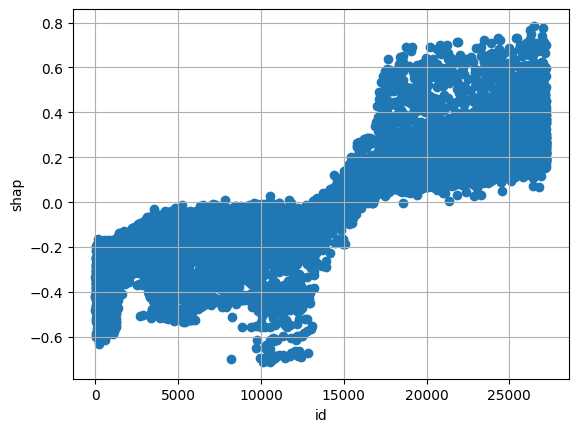

In [ ]:
plt.scatter(
    df['id'].to_numpy(),
    shap_values[:, 14]
)
plt.grid(True)
plt.xlabel('id')
plt.ylabel('shap');

Странная раскраска в примере, на который предлагается обратить внимание при построении своего графика

У id с большим значением нет отрицательных shap-values а на примере - такие имеются

Возможно я что-то не познаю в той мере в которой должен...

,dtypes,empty_str,example_1,example_2,mode_c,mode_v,nan,trash_score,unique,zero
district_name_Poselenie Moskovskij,category,-1,NaN,NaN,0.03,Poselenie Moskovskij,0.97,0.97,2,-1
district_name_Poselenie Sosenskoe,category,-1,NaN,NaN,0.056,Poselenie Sosenskoe,0.944,0.944,2,-1
district_name_Poselenie Voskresenskoe,category,-1,NaN,NaN,0.026,Poselenie Voskresenskoe,0.974,0.974,2,-1
district_name_Nekrasovka,category,-1,NaN,NaN,0.057,Nekrasovka,0.943,0.943,2,-1
total_area,int64,-1,78,43,0.064,38.0,-1,-1,208,-1
district_name_Other,category,-1,Poselenie Vnukovskoe,Birjulevo Vostochnoe,0.057,Nekrasovka,-1,-1,146,-1
district_name_Poselenie Vnukovskoe,category,-1,Poselenie Vnukovskoe,NaN,0.039,Poselenie Vnukovskoe,0.961,0.961,2,-1
rooms_num,float64,-1,3.0,NaN,0.253,2.0,0.351,0.351,13,-1
id,int64,-1,26666,243,-1,1,-1,-1,27232,-1
malls_count,int64,-1,4,17,0.067,3.0,-1,0.04,121,0.04


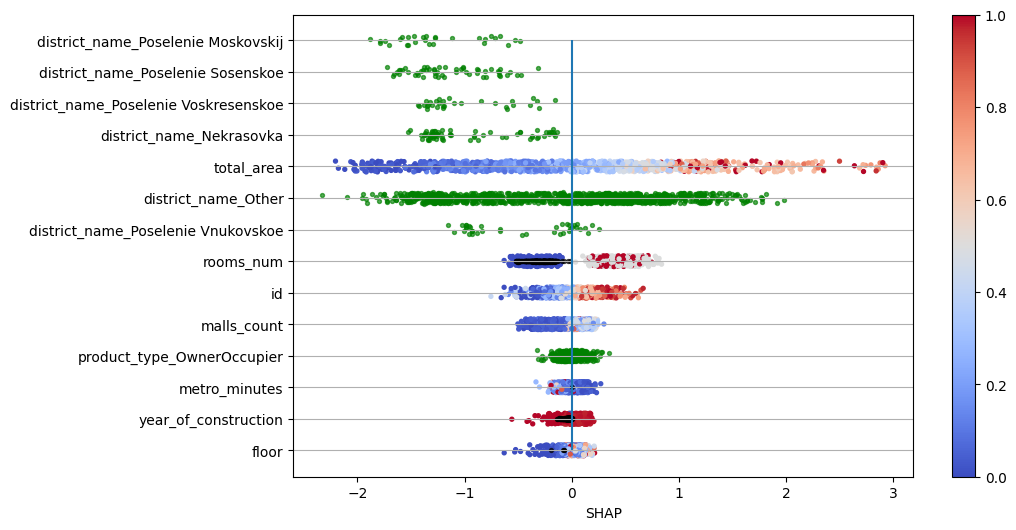

CPU times: user 1.16 s, sys: 35 ms, total: 1.2 s
Wall time: 1.71 s


In [ ]:
# ваш пример
%%time
my_beeswarm(
    df[features],
    shap_values,
    top_k_cat=5,
    top_k=14,
    max_samples_plot=1000,
    q_thr_colors=0.03,
    show_info_df=True
);

CPU times: total: 1.61 s
Wall time: 1.61 s


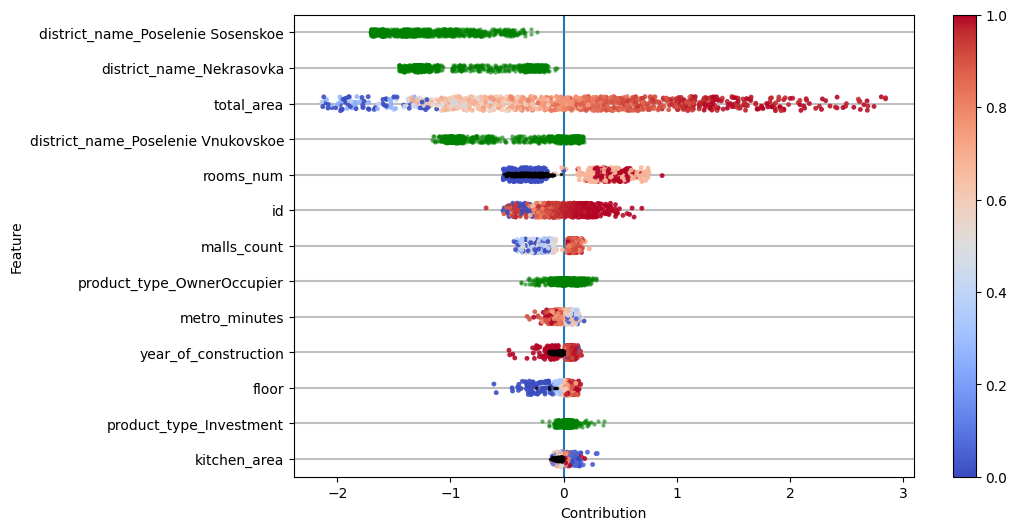

In [ ]:
%%time
from utils import shap_beeswarm

shap_beeswarm(model, df, features, cat_feature_threshold=0.001, shap_values=shap_values, top_k=13, figsize=(10, 6), dots=1000)

## 2. Логирование градиентов при обучении (4 балла)

**Задача:** хотим для каждого объекта для каждого дерева получить gi - производную лосса!
Чтобы:
- нарисовать карту объект-дерево
- поизучать 2D-представления
- призадуматься...

**Как:** придумайте способ! Нужно в процессе обучения сохранять градиенты LogLoss`а объектов на каждом дереве, после чего продемонстрировать собранные градиенты с помощью sns.clustermap.

Ниже пример. Не удаляйте пример!

In [ ]:
from scipy.special import expit

def get_split(df, val_size=0.33):
    train_idx = np.random.choice(df.index, size=int(df.shape[0]*(1-val_size)), replace=False)
    val_idx = np.setdiff1d(df.index, train_idx)
    return df.loc[train_idx].reset_index(drop=True), df.loc[val_idx].reset_index(drop=True)

In [ ]:
tr, val = get_split(df, val_size=0.23)
lgb_tr = lgb.Dataset(tr[features], tr.result_price_bin)
lgb_val = lgb.Dataset(val[features], val.result_price_bin)

grads = []
def customLogLoss(preds: np.ndarray, train_data: lgb.Dataset):
    zero_target_mask = train_data.label == 1
    probs = expit(preds)

    grad = np.where(
        zero_target_mask,
        probs - 1,
        probs
    )
    hess = probs * (1 - probs)

    grads.append(grad)
    return (grad, hess)

lgb.train(
    {
        'objective': customLogLoss,
        'metric': 'auc',
        'lambda_l2': 0.001
    },
    train_set=lgb_tr,
    num_boost_round=300,
    valid_sets=lgb_tr,
    callbacks=[lgb.log_evaluation(10)]
)

grads = np.array(grads)

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6356
[LightGBM] [Info] Number of data points in the train set: 20968, number of used features: 36
[LightGBM] [Info] Using self-defined objective function
[10]	training's auc: 0.911617
[20]	training's auc: 0.924773
[30]	training's auc: 0.933801
[40]	training's auc: 0.94128
[50]	training's auc: 0.946907
[60]	training's auc: 0.952424
[70]	training's auc: 0.957212
[80]	training's auc: 0.960201
[90]	training's auc: 0.963984
[100]	training's auc: 0.966875
[110]	training's auc: 0.969524
[120]	training's auc: 0.972055
[130]	training's auc: 0.974468
[140]	training's auc: 0.976602
[150]	training's auc: 0.978444
[160]	training's auc: 0.980318
[170]	training's auc: 0.982229
[180]	training's auc: 0.983669
[190]	training's auc: 0.985123
[200]	training's auc

CPU times: user 2min 4s, sys: 3.11 s, total: 2min 8s
Wall time: 2min 9s


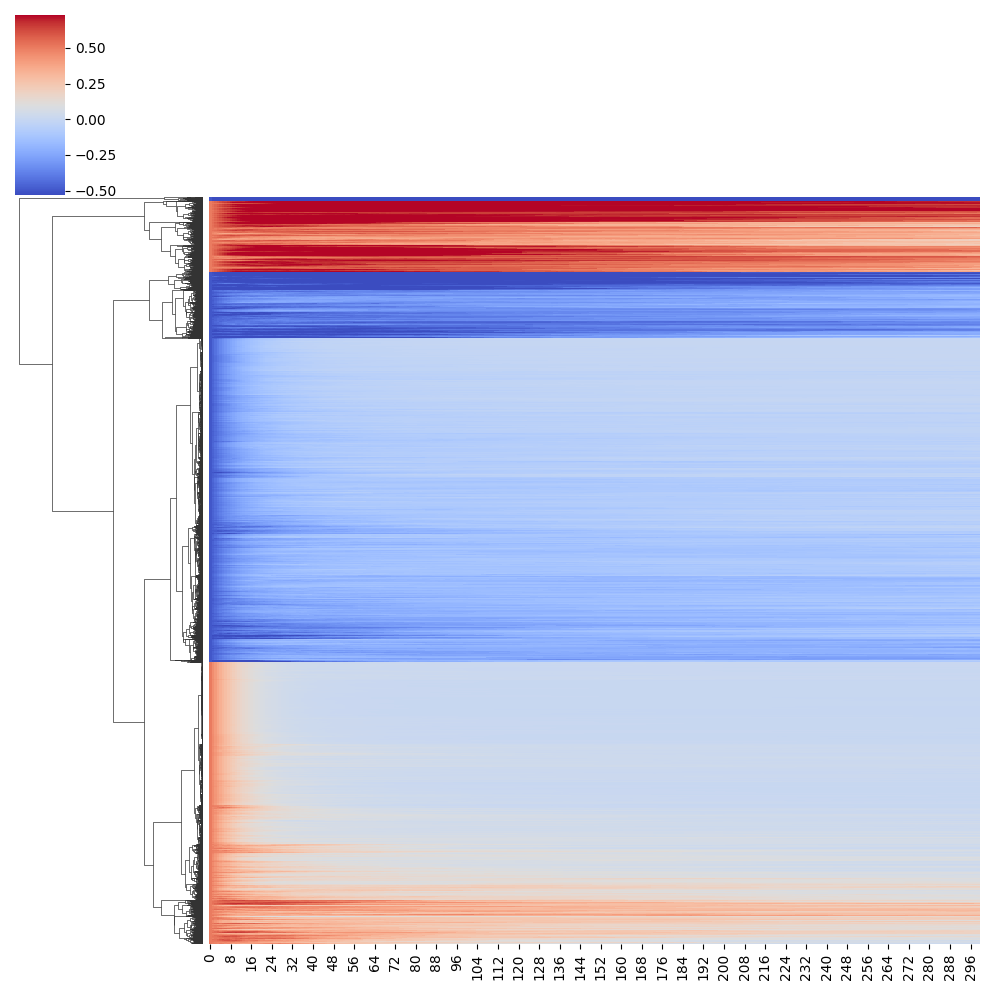

In [ ]:
%%time
sys.setrecursionlimit(100_000)

from IPython.utils import io
with io.capture_output() as captured:
    sns.clustermap(np.array(grads).T, col_cluster=False, robust=True, yticklabels=False, cmap='coolwarm')

Пример. Не удаляйте пример!

In [ ]:
def get_split(df, val_size=0.33):
    train_idx = np.random.choice(df.index, size=int(df.shape[0]*(1-val_size)), replace=False)
    val_idx = np.setdiff1d(df.index, train_idx)
    return df.loc[train_idx].reset_index(drop=True), df.loc[val_idx].reset_index(drop=True)

tr, val = get_split(df, val_size=0.23)
lgb_tr = lgb.Dataset(tr[features], tr.result_price_bin)

grads = somehow_get_grads()
grads.shape

(100, 20968)

CPU times: total: 1min 17s
Wall time: 1min 17s


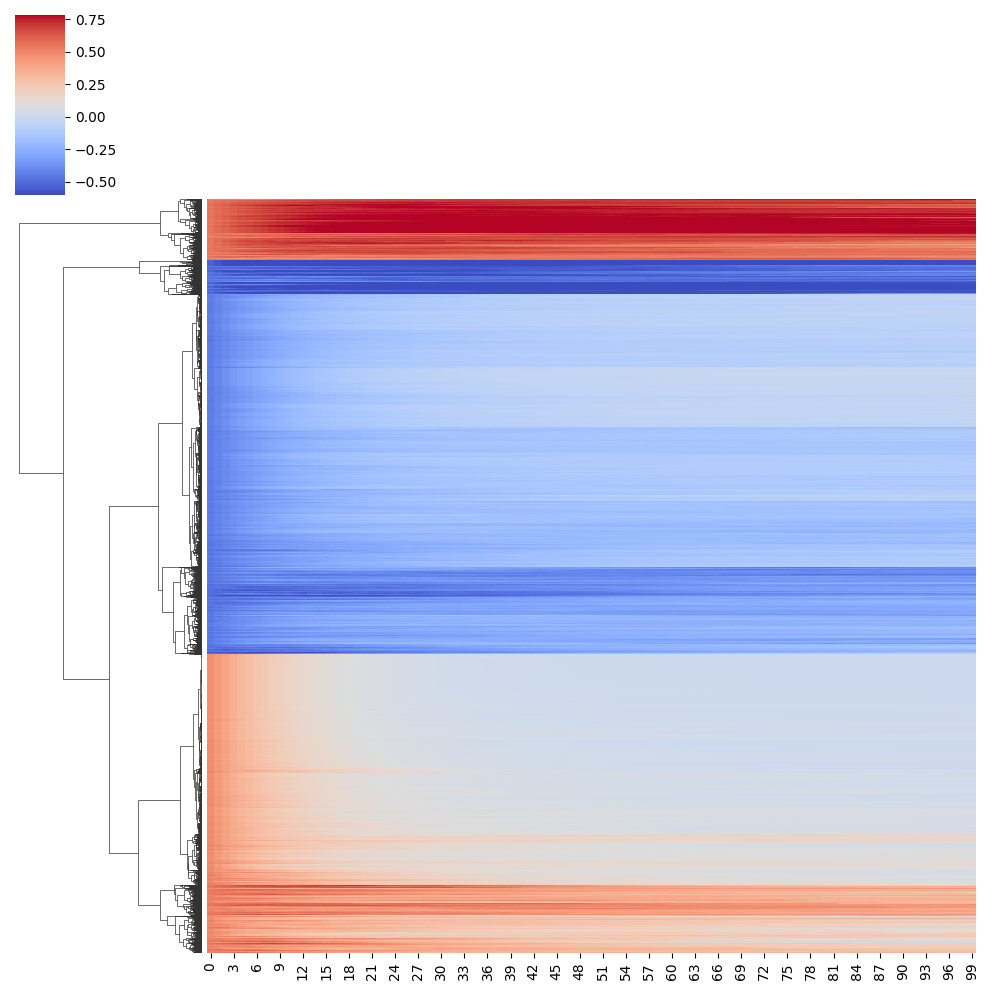

In [ ]:
%%time
import seaborn as sns

# предварительно установите fastcluster: pip install fastcluster, иначе считаться будет долго
sns.clustermap(grads.T, col_cluster=False, robust=True, yticklabels=False, cmap='coolwarm')

## 3. Автоматическое создание весов для бинарной классификации (5 баллов)

В этом блоке ваша цель - написать функцию, которая генерирует вектор весов для объектов обучающей выборки следующим образом:
1) на вход подается таргет-колонка и произвольная колонка
2) если колонка числовая, бьем ее на бины (кол-во бинов `bins` принимаем на вход. берем небольшое, около 7-13)
    - если в колонке < `bins` уникальных, бить не надо
3) если колонка категориальная, тоже бьем ее на бины
    - если уникальных значений <= `bins`, то за бины считаем уникальные значения категории
    - если уникальных значений >  `bins`, то выбираем `bins` - 1 самых популярных категорий у объектов класса 1
    - не попавшие в топ самых популярных категории запихиваем в бин 'other'

4) проходимся по всем бинам, присваивая всем объектам класса 1, попавшим в бин, вес n_0_in_bin / n_1_in_bin,
       если объектов класса 0, попавших в этот бин, достаточное кол-во (принимайте на вход, зависит от задачи)

5) всем объектам класса 0 присваиваем вес, равный единице

Такая схема на практике работает лучше, чем обычный `scale_pos_weight` параметр в LightGBM и его аналоги, если разумно выбирать
    вспомогательную колонку. Подумайте, как именно нужно выбирать такую колонку. Ответ писать не обязательно, но можно :)

**Обязательно:**
Найдите способ продемонстрировать визуализацией, что ваша функция работает корректно!

In [ ]:
def weights(
    target_col: pd.Series,
    bin_col: pd.Series,
    bins: int,
    show_w_table: bool = True
):
    if bin_col.dtype == 'category':
        hist_col = bin_col.value_counts(sort=True)

        if hist_col.shape[0] > bins:
            other_vals = hist_col.iloc[bins - 1:].index
            bin_col = bin_col.replace(other_vals, 'Other')
    else:
        n_unique = bin_col.nunique()
        if n_unique >= bins:
            bin_col = pd.qcut(bin_col, bins)

    weights = pd.DataFrame({
        'bin': bin_col,
        'target': target_col
    }).groupby('bin').agg(
        n_in_bin=('target', 'count'),
        n_1_in_bin=('target', 'sum')
    )
    weights['n_0_in_bin'] = weights['n_in_bin'] - weights['n_1_in_bin']
    weights['w'] = weights['n_0_in_bin'] / weights['n_1_in_bin']

    if show_w_table:
        print(weights)

    res = pd.DataFrame(bin_col).merge(
        weights.reset_index(),
        left_on=bin_col.name,
        right_on='bin',
        how='inner'
    )

    res.loc[target_col == 0, 'w'] = 1.0
    return res['w'], bin_col

In [ ]:
# categorical case
with warnings.catch_warnings(action="ignore"):
    w, bin_col = weights(
        df['result_price_bin'],
        df['district_name'],
        bins=7,
        show_w_table=True
    )
    df['w'] = w
    df['bin_col'] = bin_col

                         n_in_bin  n_1_in_bin  n_0_in_bin         w
bin                                                                
Other                       20959       11955        9004  0.753158
Mitino                        624         516         108  0.209302
Nekrasovka                   1547         562         985  1.752669
Poselenie Moskovskij          815         230         585  2.543478
Poselenie Sosenskoe          1526         392        1134  2.892857
Poselenie Vnukovskoe         1064         463         601  1.298056
Poselenie Voskresenskoe       697         199         498  2.502513


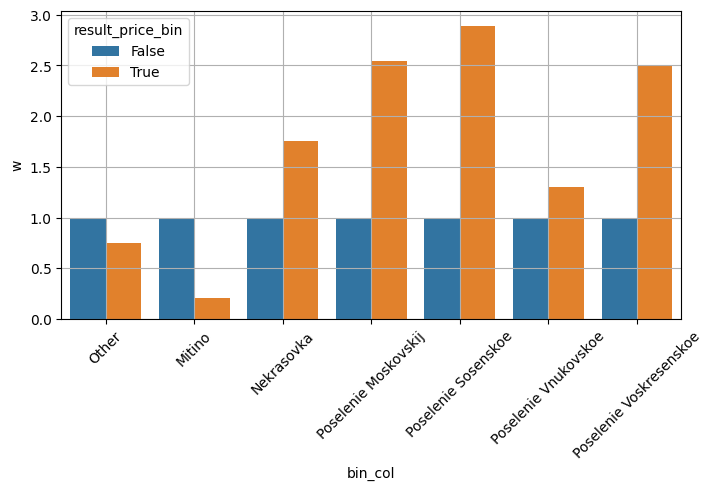

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.barplot(
    df,
    x='bin_col',
    y='w',
    hue='result_price_bin',
    legend=True,
    ax=ax
);
plt.xticks(rotation=45)
ax.grid(True);

In [ ]:
# numeric case
with warnings.catch_warnings(action="ignore"):
    w, bin_col = weights(
        df['result_price_bin'],
        df['district_area'],
        bins=7,
        show_w_table=True
    )
    df['w'] = w
    df['bin_col'] = bin_col

                            n_in_bin  n_1_in_bin  n_0_in_bin         w
bin                                                                   
(2081627.76, 5293464.965]       3897        2485        1412  0.568209
(5293464.965, 7587523.226]      3956        2429        1527  0.628654
(7587523.226, 8993640.418]      3867        1961        1906  0.971953
(8993640.418, 11391678.48]      4754        2494        2260  0.906175
(11391678.48, 15319902.35]      3015        1994        1021  0.512036
(15319902.35, 26155137.04]      4107        2097        2010  0.958512
(26155137.04, 206071809.2]      3636         857        2779  3.242707


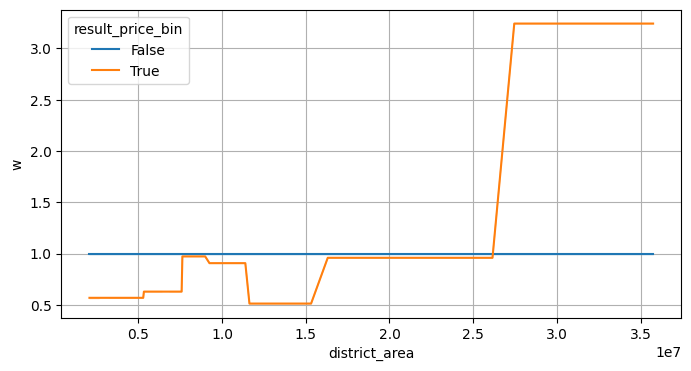

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.lineplot(
    df.loc[df.district_area <= 40_155_137].sort_values('district_area'),
    x='district_area',
    y='w',
    hue='result_price_bin',
    legend=True,
    ax=ax
);
ax.grid(True);